In [255]:
import torch
import pandas as pd
import numpy as np
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [256]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [257]:
RANDOM_SEED = 45

In [258]:
df: pd.DataFrame = pd.read_csv('../data/row/train.csv')

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [259]:
df_result = pd.read_csv('../data/row/test.csv')

df_result.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [260]:
count_vactorizer = feature_extraction.text.CountVectorizer()

vectors = count_vactorizer.fit_transform(df.text)

vectors_array = vectors.toarray()

In [261]:
X_tensor = torch.tensor(vectors_array, dtype=torch.float32, device=device)
y_tensor = torch.tensor(df.target, dtype=torch.float32, device=device)

X_tensor.shape, y_tensor.shape, X_tensor.device, y_tensor.device

(torch.Size([7613, 21637]),
 torch.Size([7613]),
 device(type='mps', index=0),
 device(type='mps', index=0))

In [262]:
result_vectors = count_vactorizer.transform(df_result.text)

result_array = result_vectors.toarray()

result_tensor = torch.tensor(result_array, dtype=torch.float32).to(device)

result_tensor.shape

torch.Size([3263, 21637])

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X_train)

(torch.Size([6090, 21637]),
 torch.Size([1523, 21637]),
 torch.Size([6090]),
 torch.Size([1523]),
 torch.Tensor)

In [264]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [265]:
class NNClassifierV0(nn.Module):
    def __init__(self) -> None:
        super(NNClassifierV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=X_train.shape[1], out_features=16),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=16, out_features=8),
            # nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=8, out_features=1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [266]:
torch.manual_seed(RANDOM_SEED)
model_1 = NNClassifierV0()
model_1.to(device)

model_1.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[-0.0043,  0.0063,  0.0025,  ..., -0.0029, -0.0028, -0.0036],
                      [ 0.0012, -0.0027, -0.0017,  ..., -0.0011,  0.0023, -0.0021],
                      [ 0.0017,  0.0023, -0.0021,  ...,  0.0059, -0.0052,  0.0023],
                      ...,
                      [-0.0007, -0.0051,  0.0012,  ...,  0.0037, -0.0004,  0.0017],
                      [ 0.0017,  0.0043,  0.0048,  ..., -0.0044,  0.0058,  0.0064],
                      [ 0.0023, -0.0056,  0.0046,  ..., -0.0033, -0.0050, -0.0061]],
                     device='mps:0')),
             ('layer_stack.0.bias',
              tensor([ 0.0011, -0.0058,  0.0040, -0.0057, -0.0005, -0.0007, -0.0053, -0.0016,
                       0.0023, -0.0059, -0.0004, -0.0015,  0.0066,  0.0018, -0.0062, -0.0035],
                     device='mps:0')),
             ('layer_stack.3.weight',
              tensor([[-0.0142, -0.0791,  0.2409, -0.1640,  0.0445, -0.1940, -0.1142, -0.

In [267]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model_1.parameters(), lr=0.0001)

In [268]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [269]:
torch.manual_seed(RANDOM_SEED)
EPOCHS = 100

for epoch in range(EPOCHS):
    
    train_loss, train_acc = 0, 0
    for X, y in train_dataloader:
        model_1.train()
        y_logits = model_1(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits, y)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_logits = model_1(X).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss += loss_fn(test_logits, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{EPOCHS}, {train_loss = :.4f}, {train_acc = :.2f}%, {test_loss = :.4f}, {test_acc = :.2f}%')

Epoch: 10/100, train_loss = 0.5553, train_acc = 82.18%, test_loss = 0.5660, test_acc = 78.25%
Epoch: 20/100, train_loss = 0.4309, train_acc = 90.27%, test_loss = 0.4976, test_acc = 79.86%
Epoch: 30/100, train_loss = 0.2938, train_acc = 92.83%, test_loss = 0.4456, test_acc = 81.18%
Epoch: 40/100, train_loss = 0.2177, train_acc = 94.19%, test_loss = 0.4595, test_acc = 80.86%
Epoch: 50/100, train_loss = 0.1675, train_acc = 95.60%, test_loss = 0.5094, test_acc = 80.66%
Epoch: 60/100, train_loss = 0.1276, train_acc = 96.79%, test_loss = 0.5721, test_acc = 80.47%
Epoch: 70/100, train_loss = 0.1089, train_acc = 97.15%, test_loss = 0.6601, test_acc = 79.49%
Epoch: 80/100, train_loss = 0.0925, train_acc = 97.61%, test_loss = 0.7576, test_acc = 79.29%
Epoch: 90/100, train_loss = 0.0846, train_acc = 97.59%, test_loss = 0.8544, test_acc = 78.97%
Epoch: 100/100, train_loss = 0.0815, train_acc = 97.41%, test_loss = 0.9540, test_acc = 78.45%


In [270]:
model_1.eval()
with torch.inference_mode():
    y_test_pred = torch.round(torch.sigmoid(model_1(X_test).squeeze())).cpu()
y_test = y_test.cpu()
y_test_pred, y_test

(tensor([0., 0., 1.,  ..., 0., 0., 1.]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]))

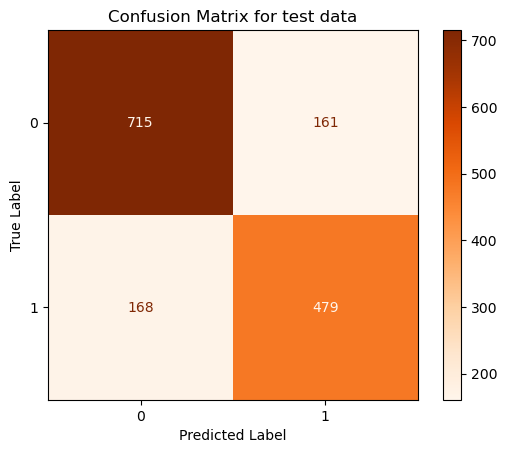

In [271]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

display.plot(cmap=plt.cm.Oranges)

plt.title('Confusion Matrix for test data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [272]:
model_1.eval()
with torch.inference_mode():
    result_logits = model_1(result_tensor).squeeze()
    result_labels = torch.round(torch.sigmoid(result_logits))
result_labels.shape

torch.Size([3263])

In [273]:
result_labels_np = result_labels.cpu().numpy().astype(int)

result_labels_np

array([1, 0, 1, ..., 1, 1, 1])

In [274]:
df_result['target'] = result_labels_np

In [275]:
df_result[['text', 'target']][df_result['target'] == 0].sample(10, random_state=RANDOM_SEED)

,text,target
2506,fUCK I CANT WAIT TO RUIN AUBREY'S WHOLE FIC AN...,0
2456,@hawk_nancy Discovered by @NickCannon \n Liste...,0
1081,Shaping the to come: multimillion chop local b...,0
440,?? New Ladies Shoulder Tote #Handbag Faux Leat...,0
1222,paladins is going to be a disaster,0
2625,Ebay Snipe RT? http://t.co/tRw1OmykQz Whelen S...,0
1754,Politicians are using false allegations to att...,0
370,Oh I see we are now tied? Sweet! It's all in...,0
12,No don't tell me that!,0
1917,@LoganMeadows11 @ChristianStec_ he's weak sauc...,0


In [276]:
df_result[['text', 'target']][df_result['target'] == 1].sample(10)

,text,target
1717,Hvy rain wind sm hail Tree down on Bluff Ridge...,1
2475,@foxandfriends where is protest looting and ri...,1
1602,'We must educate first responders about how to...,1
765,Call to car vs fed ex truck head on collision ...,1
920,This wall is going to be the death of me...due...,1
1236,#mightyworld Thousands displaced after monsoon...,1
39,On the #M42 northbound between junctions J3 an...,1
263,FedEx stops shipping potential bioterror patho...,1
1791,Yeah it actually is this whole week we in a he...,1
2279,Pandemonium In Aba As Woman Delivers Baby With...,1


In [277]:
df_result[['text', 'target']].sample(10, random_state=45)

,text,target
1772,#ine #instyle Olap #world pres: http://t.co/PJ...,1
12,No don't tell me that!,0
2569,*aggressively screams* https://t.co/8bHaejsUUt,0
1731,Boston yesterday after an intense hailstorm. P...,1
230,Car Receiving tube Installation for Avalanche ...,0
108,***Latest Updates on the Salt River Wild Horse...,0
258,FedEx no longer to transport bioterror germs i...,1
666,If a å£1 rise in wages is going to have such a...,0
1551,@martinsymiguel @FilipeCoelho92 FATALITY,0
1628,*NEW* Snap On Tools Black baseball Hat/Cap Sil...,0


In [279]:
df_result[['id', 'target']].to_csv('../data/processed/submission_3.csv', index=False)